In [1]:
import sys
print("Versão do python utilizada nesse notebook:",sys.version)

Versão do python utilizada nesse notebook: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report


In [14]:
dataset_path = "C:/Users/Usuário/railway_fault_detection\Railway Track fault Detection Updated"

In [15]:
import os

# Verificar se o caminho existe
if os.path.exists(dataset_path):
    print("✅ Caminho encontrado!")
else:
    print("❌ Caminho incorreto, verifique o nome da pasta.")


✅ Caminho encontrado!


In [16]:
    print("\nPastas no dataset:", os.listdir(dataset_path))

    # Caminho do conjunto de treino
    train_path = os.path.join(dataset_path, "Train")

    # Verificar classes e quantidade de imagens por classe
    if os.path.exists(train_path):
        for classe in os.listdir(train_path):
            num_imgs = len(os.listdir(os.path.join(train_path, classe)))
            print(f"📂 Classe '{classe}': {num_imgs} imagens")
    else:
        print("🚨 ERRO: Pasta 'Train' não encontrada dentro do dataset!")


Pastas no dataset: ['Test', 'Train', 'Validation']
📂 Classe 'Defective': 150 imagens
📂 Classe 'Non defective': 150 imagens


In [20]:
# Verificar se OpenCV consegue abrir as imagens
for img_name in defective_images:
    img_path = os.path.join(defective_path, img_name)
    img = cv2.imread(img_path)

    if img is None:
        print(f"🚨 ERRO: OpenCV não conseguiu carregar {img_name}")
    else:
        print(f"✅ Sucesso: OpenCV carregou {img_name}")


🚨 ERRO: OpenCV não conseguiu carregar IMG_20201114_101700.jpg
🚨 ERRO: OpenCV não conseguiu carregar IMG_20201211_113656.jpg
🚨 ERRO: OpenCV não conseguiu carregar IMG_20201114_102726.jpg


In [21]:
# Verificar a extensão dos arquivos na pasta Defective
print("Extensões das imagens em 'Defective':")
for img_name in os.listdir(defective_path)[:10]:
    print(img_name, "->", img_name.split(".")[-1])  # Exibir extensão do arquivo

# Verificar a extensão dos arquivos na pasta Non Defective
print("\nExtensões das imagens em 'Non Defective':")
for img_name in os.listdir(non_defective_path)[:10]:
    print(img_name, "->", img_name.split(".")[-1])  # Exibir extensão do arquivo


Extensões das imagens em 'Defective':
131004959_171473721383413_8222187747086021011_n.jpg -> jpg
131051004_382613492830631_1306891331783850055_n.jpg -> jpg
131065180_999185033824671_7735147288489715620_n.jpg -> jpg
131084537_190751489449739_279862595635733772_n.jpg -> jpg
131092897_149705809860659_8798464983059531038_n.jpg -> jpg
131098429_134147575143001_1246437012995704959_n.jpg -> jpg
131129946_140815574232570_8925999503657494497_n.jpg -> jpg
131275810_2686956714949012_5021348409242545922_n.jpg -> jpg
131348023_405054987354853_8834671660058234194_n.jpg -> jpg
131437543_500273490949549_5045378072687137331_n.jpg -> jpg

Extensões das imagens em 'Non Defective':
IMG_20201114_100021.jpg -> jpg
IMG_20201114_100032.jpg -> jpg
IMG_20201114_100044.jpg -> jpg
IMG_20201114_100046.jpg -> jpg
IMG_20201114_100050.jpg -> jpg
IMG_20201114_100052.jpg -> jpg
IMG_20201114_100101.jpg -> jpg
IMG_20201114_100107.jpg -> jpg
IMG_20201114_100110.jpg -> jpg
IMG_20201114_100114.jpg -> jpg


In [22]:
from PIL import Image

# Testar se PIL consegue abrir as imagens que o OpenCV não conseguiu
for img_name in defective_images:
    img_path = os.path.join(defective_path, img_name)
    
    try:
        img = Image.open(img_path)
        print(f"✅ PIL conseguiu abrir {img_name}")
    except Exception as e:
        print(f"🚨 ERRO: PIL também falhou ao abrir {img_name} - {e}")


✅ PIL conseguiu abrir IMG_20201114_101700.jpg
✅ PIL conseguiu abrir IMG_20201211_113656.jpg
✅ PIL conseguiu abrir IMG_20201114_102726.jpg


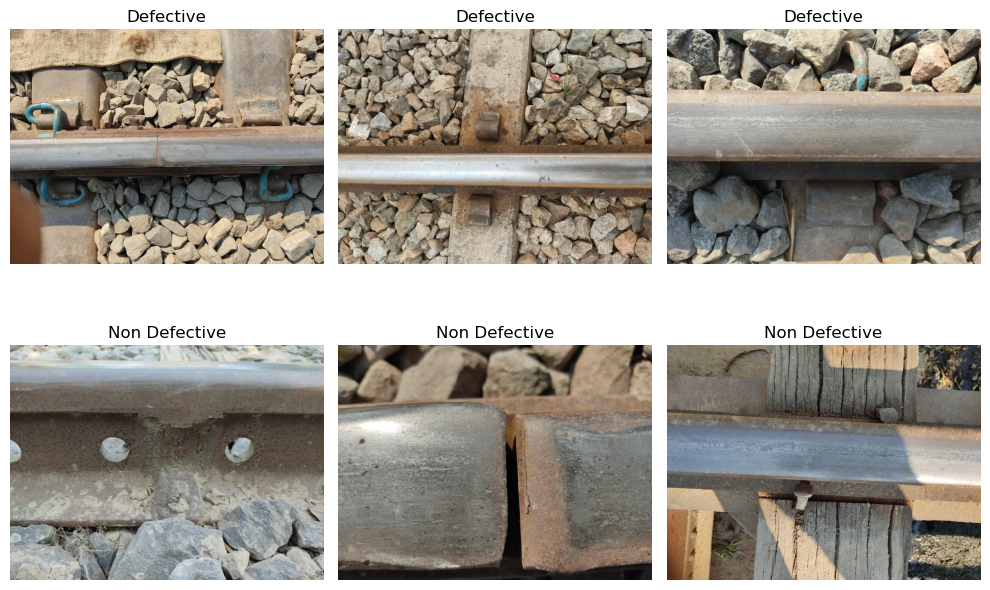

In [23]:
# Criar um grid de imagens
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

# Exibir imagens de trilhos com falha usando PIL
i = 0
for img_name in defective_images:
    img_path = os.path.join(defective_path, img_name)
    
    try:
        img = Image.open(img_path)
        img = img.convert("RGB")  # Garantir que está no formato correto
        axes[0, i].imshow(img)
        axes[0, i].set_title("Defective")
        axes[0, i].axis("off")
        i += 1
    except:
        print(f"🚨 Imagem corrompida: {img_name}")

    if i == 3:
        break  # Exibir apenas 3 imagens

# Exibir imagens de trilhos sem falha usando PIL
i = 0
for img_name in non_defective_images:
    img_path = os.path.join(non_defective_path, img_name)
    
    try:
        img = Image.open(img_path)
        img = img.convert("RGB")
        axes[1, i].imshow(img)
        axes[1, i].set_title("Non Defective")
        axes[1, i].axis("off")
        i += 1
    except:
        print(f"🚨 Imagem corrompida: {img_name}")

    if i == 3:
        break  # Exibir apenas 3 imagens

plt.tight_layout()
plt.show()


In [24]:
datagen = ImageDataGenerator(
    rescale=1./255,        # Normaliza os pixels (de 0-255 para 0-1)
    rotation_range=20,      # Rotação aleatória de até 20 graus
    width_shift_range=0.2,  # Deslocamento horizontal aleatório
    height_shift_range=0.2, # Deslocamento vertical aleatório
    shear_range=0.2,        # Transformação no eixo (shear)
    zoom_range=0.2,         # Zoom aleatório
    horizontal_flip=True,   # Inverte algumas imagens horizontalmente
    validation_split=0.2    # Usa 80% para treino e 20% para validação
)

# Carregar dados de treino e validação
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),  # Redimensionar as imagens para 224x224 pixels
    batch_size=32,
    class_mode='binary',     # Como temos 2 classes (Defective e Non Defective)
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 240 images belonging to 2 classes.
Found 59 images belonging to 2 classes.


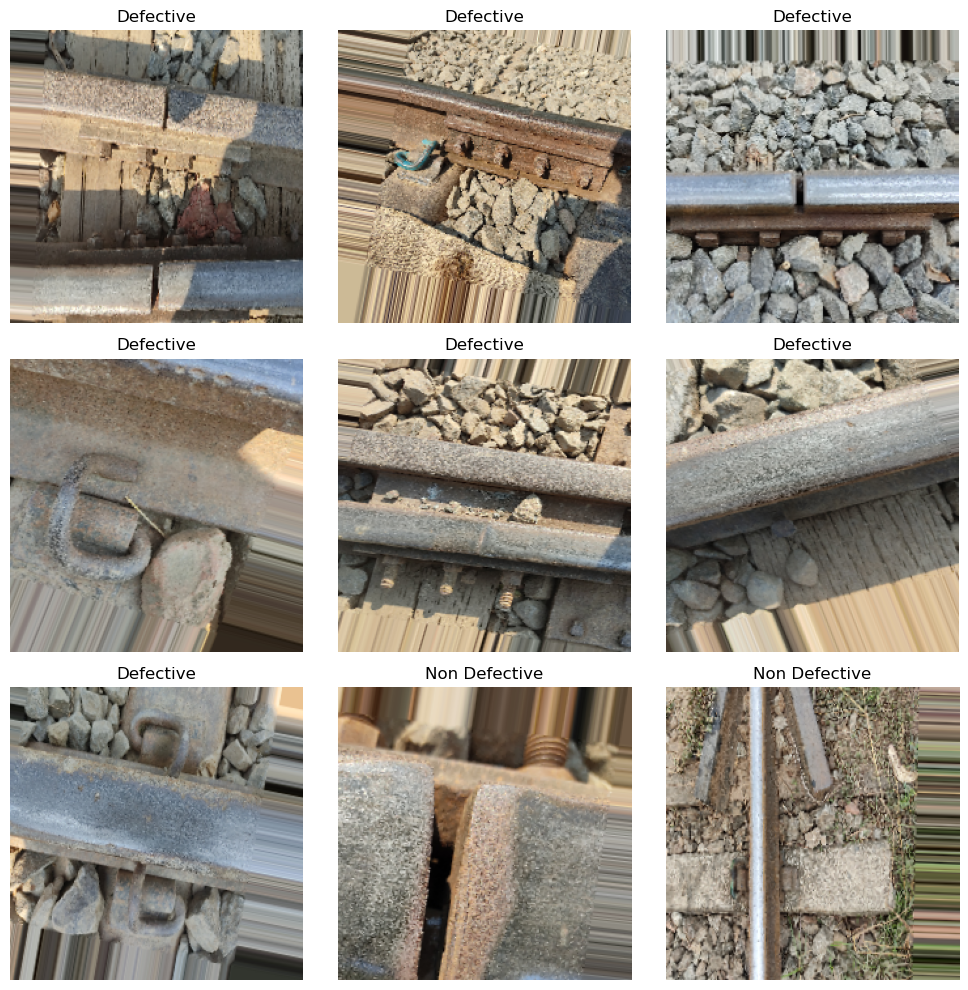

In [25]:
batch_images, batch_labels = next(train_generator)

# Criar um grid de imagens
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):  # Mostrar 9 imagens
    img = batch_images[i]
    label = "Defective" if batch_labels[i] == 1 else "Non Defective"
    
    axes[i//3, i%3].imshow(img)
    axes[i//3, i%3].set_title(label)
    axes[i//3, i%3].axis("off")

plt.tight_layout()
plt.show()

In [27]:
# Criar a CNN
model = Sequential([
    # Primeira camada convolucional
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),

    # Segunda camada convolucional
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Terceira camada convolucional
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Camada Flatten para transformar a matriz em vetor
    Flatten(),

    # Camada totalmente conectada
    Dense(512, activation='relu'),
    Dropout(0.5),  # Evita overfitting

    # Camada de saída (sigmoid pois temos apenas 2 classes)
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Mostrar o resumo do modelo
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [28]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Ajuste conforme necessário
    verbose=1
)

Epoch 1/10
8/8 [==============================] - 92s 11s/step - loss: 1.6130 - accuracy: 0.5333 - val_loss: 0.6977 - val_accuracy: 0.5085
Epoch 2/10
8/8 [==============================] - 76s 10s/step - loss: 0.6861 - accuracy: 0.5375 - val_loss: 0.6911 - val_accuracy: 0.4915
Epoch 3/10
8/8 [==============================] - 74s 9s/step - loss: 0.6931 - accuracy: 0.5292 - val_loss: 0.6793 - val_accuracy: 0.6780
Epoch 4/10
8/8 [==============================] - 75s 10s/step - loss: 0.6919 - accuracy: 0.5625 - val_loss: 0.6347 - val_accuracy: 0.4915
Epoch 5/10
8/8 [==============================] - 75s 9s/step - loss: 0.6937 - accuracy: 0.5125 - val_loss: 0.6814 - val_accuracy: 0.5254
Epoch 6/10
8/8 [==============================] - 69s 9s/step - loss: 0.6847 - accuracy: 0.5292 - val_loss: 0.6695 - val_accuracy: 0.5424
Epoch 7/10
8/8 [==============================] - 72s 9s/step - loss: 0.6823 - accuracy: 0.5125 - val_loss: 0.6594 - val_accuracy: 0.6271
Epoch 8/10
8/8 [===============

In [29]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Acurácia no conjunto de validação: {accuracy:.2f}")

2/2 [==============================] - 8s 4s/step - loss: 0.6659 - accuracy: 0.5593
Acurácia no conjunto de validação: 0.56


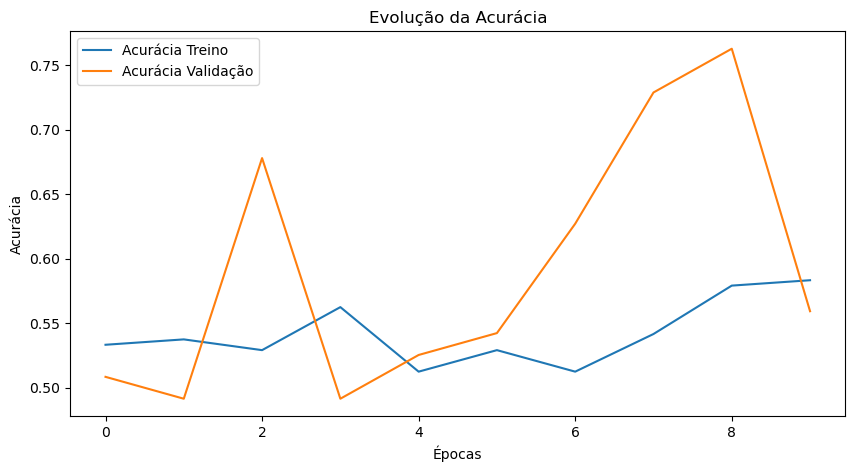

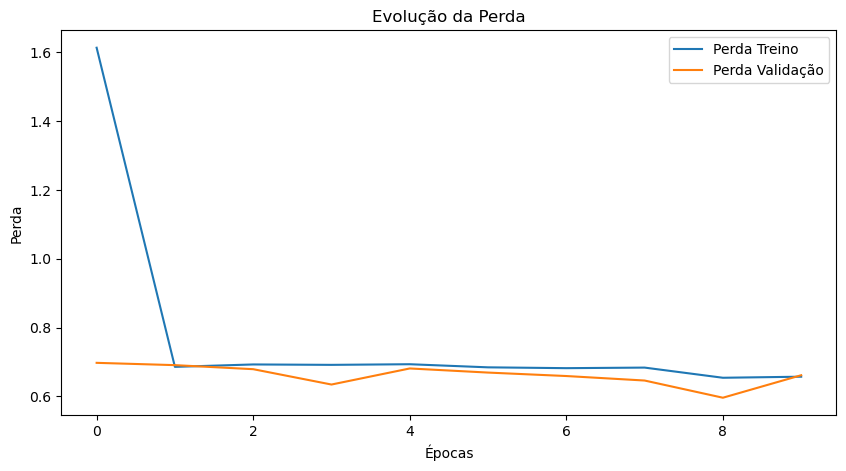

In [30]:
# Plotar a curva de aprendizado
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title("Evolução da Acurácia")
plt.show()

# Plotar a perda (loss)
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Perda Treino')
plt.plot(history.history['val_loss'], label='Perda Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title("Evolução da Perda")
plt.show()


In [33]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas do modelo pré-treinado para não serem ajustadas
for layer in base_model.layers:
    layer.trainable = False

# Adicionar novas camadas personalizadas no topo
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduz a dimensionalidade
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Evita overfitting
x = Dense(1, activation='sigmoid')(x)  # Camada de saída para classificação binária

# Criar o novo modelo
model_vgg16 = Model(inputs=base_model.input, outputs=x)

# Compilar o modelo
model_vgg16.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

# Resumo do modelo
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
# Treinar o modelo com VGG16
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Ajuste conforme necessário
    verbose=1
)


Epoch 1/10
8/8 [==============================] - 107s 13s/step - loss: 0.7312 - accuracy: 0.5167 - val_loss: 0.6590 - val_accuracy: 0.5932
Epoch 2/10
8/8 [==============================] - 93s 11s/step - loss: 0.6714 - accuracy: 0.5875 - val_loss: 0.6865 - val_accuracy: 0.5763
Epoch 3/10
8/8 [==============================] - 88s 11s/step - loss: 0.6192 - accuracy: 0.6667 - val_loss: 0.6328 - val_accuracy: 0.5932
Epoch 4/10
8/8 [==============================] - 90s 11s/step - loss: 0.6134 - accuracy: 0.6500 - val_loss: 0.6423 - val_accuracy: 0.6610
Epoch 5/10
8/8 [==============================] - 83s 10s/step - loss: 0.5802 - accuracy: 0.7000 - val_loss: 0.5783 - val_accuracy: 0.6949
Epoch 6/10
8/8 [==============================] - 82s 10s/step - loss: 0.5761 - accuracy: 0.6875 - val_loss: 0.6232 - val_accuracy: 0.6949
Epoch 7/10
8/8 [==============================] - 97s 12s/step - loss: 0.5566 - accuracy: 0.7208 - val_loss: 0.5691 - val_accuracy: 0.7119
Epoch 8/10
8/8 [==========

In [35]:
loss, accuracy = model_vgg16.evaluate(validation_generator)
print(f"Acurácia do modelo VGG16 no conjunto de validação: {accuracy:.2f}")

2/2 [==============================] - 16s 6s/step - loss: 0.5375 - accuracy: 0.7627
Acurácia do modelo VGG16 no conjunto de validação: 0.76


In [41]:
def generate_gradcam(model, img_array, last_conv_layer_name="block5_conv3"):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Corrigir conversão para NumPy
    heatmap = np.array(heatmap)  # Converte para NumPy corretamente
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)  # Normalizar o mapa

    return heatmap

2/2 [==============================] - 19s 7s/step


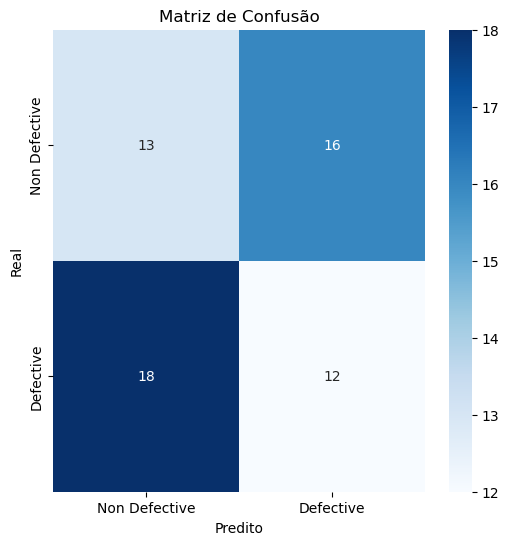

               precision    recall  f1-score   support

Non Defective       0.42      0.45      0.43        29
    Defective       0.43      0.40      0.41        30

     accuracy                           0.42        59
    macro avg       0.42      0.42      0.42        59
 weighted avg       0.42      0.42      0.42        59



In [46]:
# Obter previsões no conjunto de validação
y_pred = model_vgg16.predict(validation_generator)
y_pred = (y_pred > 0.5).astype(int)  # Converter para 0 ou 1

# Obter rótulos verdadeiros
y_true = validation_generator.classes

# Criar matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Visualizar matriz de confusão
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non Defective', 'Defective'], yticklabels=['Non Defective', 'Defective'])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Relatório de classificação
print(classification_report(y_true, y_pred, target_names=['Non Defective', 'Defective']))

2/2 [==============================] - 17s 6s/step


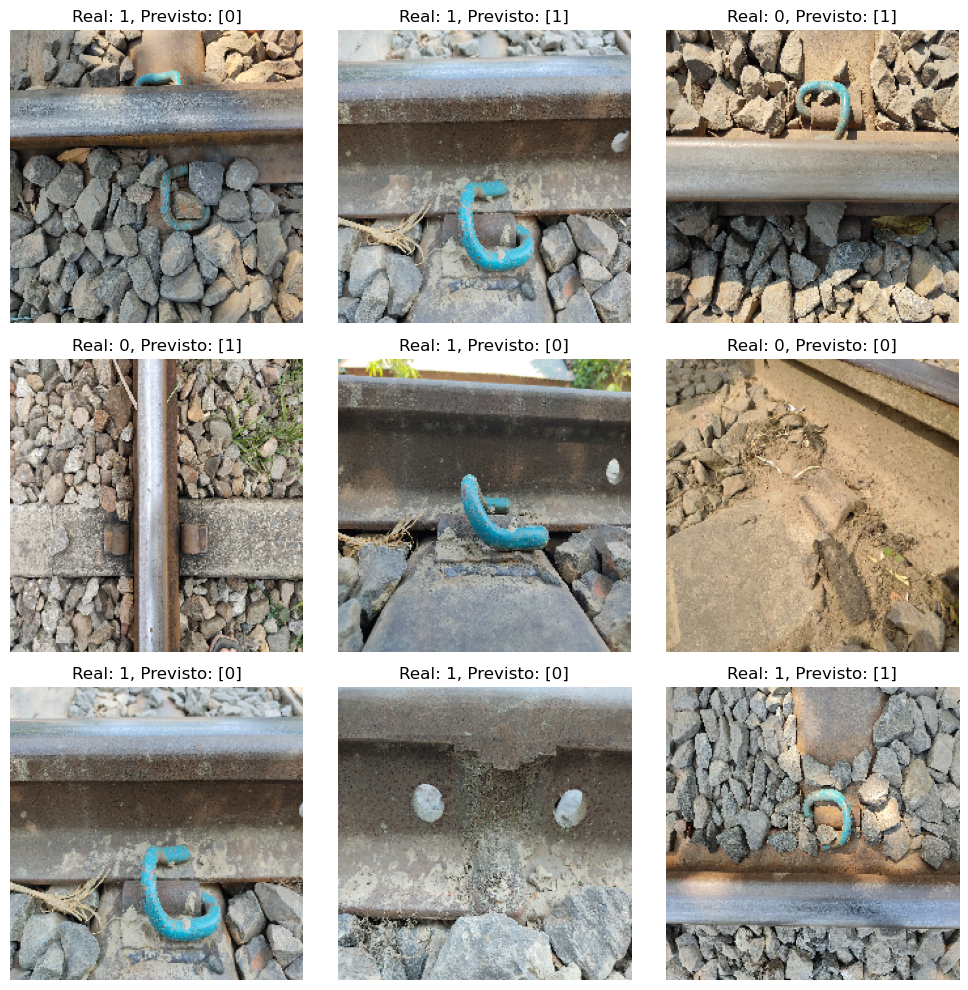

In [48]:
# Obter nomes das imagens
file_paths = validation_generator.filepaths

# Obter previsões e rótulos verdadeiros
y_pred_probs = model_vgg16.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = validation_generator.classes

# Identificar índices das previsões erradas
wrong_preds_idx = np.where(y_pred != y_true)[0]

# Selecionar algumas imagens erradas aleatoriamente
num_images = 9
sample_idx = random.sample(list(wrong_preds_idx), min(num_images, len(wrong_preds_idx)))

# Criar grid para exibir imagens erradas
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, idx in enumerate(sample_idx):
    img_path = file_paths[idx]
    img = image.load_img(img_path, target_size=(224, 224))

    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.set_title(f"Real: {y_true[idx]}, Previsto: {y_pred[idx]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [49]:
def generate_gradcam(model, img_array, last_conv_layer_name="block5_conv3"):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)  # Normalizar o mapa
    return heatmap


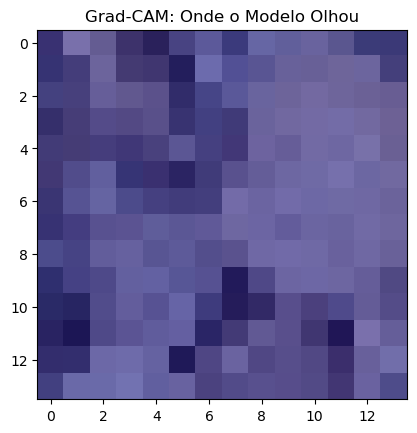

In [50]:
# Escolher uma imagem errada
img_path = file_paths[wrong_preds_idx[0]]

# Carregar e processar a imagem
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Gerar heatmap Grad-CAM
heatmap = generate_gradcam(model_vgg16, img_array)

# Exibir imagem com o heatmap sobreposto
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Grad-CAM: Onde o Modelo Olhou")
plt.show()


In [55]:
# Salvar o modelo treinado
model_vgg16.save("modelo_vgg16_trilhos.h5")